| Elemento | Descripción |
|-----------|-------------|
| **Escudos** | <p align="center"><img src="./Imagenes/TECNM.png" width="150"/> <img src="./Imagenes/MSC.png" width="150"/></p> |
| **Maestría** | Maestría en Sistemas Computacionales |
| **Asignatura** | Visión Artificial |
| **Proyecto** | Transformaciones geométricas afines |
| **Autor** | Alan García Díaz |
| **Fecha de entrega** | 22/11/2025 |

# Introducción
La transformación afín es un proceso geométrico que permite modificar una imagen mediante rotaciones, escalados, traslaciones y sesgados.
Se utiliza ampliamente en visión por computadora para cambiar la perspectiva o posición de una imagen preservando paralelismo de líneas.

# Enunciado del problema
Implementar un algoritmo capaz de aplicar una transformación afín a una imagen en escala de grises.
Dado que la transformación produce huecos, estos deben rellenarse mediante interpolación bilineal.

# Objetivo General
Aplicar correctamente una transformación afín a una imagen en escala de grises utilizando interpolación bilineal para evitar pérdida de información.

## Objetivos Específicos
- Implementar la transformación afín utilizando coordenadas homogéneas.
- Aplicar la transformación inversa para evitar huecos en la imagen resultante.
- Implementar interpolación bilineal para completar valores faltantes.
- Generar la imagen transformada como salida.

# Desarrollo
A continuación se presenta el código completo que realiza la transformación afín y rellena valores mediante interpolación bilineal:

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

In [2]:
def bilinear_interpolation(img, x, y):
    h, w = img.shape
    x0 = int(np.floor(x)); x1 = x0 + 1
    y0 = int(np.floor(y)); y1 = y0 + 1
    if x0 < 0 or x1 >= w or y0 < 0 or y1 >= h:
        return 0
    Ia = img[y0, x0]; Ib = img[y0, x1]
    Ic = img[y1, x0]; Id = img[y1, x1]
    wa = (x1 - x) * (y1 - y)
    wb = (x - x0) * (y1 - y)
    wc = (x1 - x) * (y - y0)
    wd = (x - x0) * (y - y0)
    return wa*Ia + wb*Ib + wc*Ic + wd*Id

In [3]:
def affine_transform(img, M):
    h, w = img.shape
    M_inv = np.linalg.inv(M)
    out = np.zeros_like(img)
    for y_out in range(h):
        for x_out in range(w):
            dest = np.array([x_out, y_out, 1])
            x_src, y_src, _ = M_inv @ dest
            out[y_out, x_out] = bilinear_interpolation(img, x_src, y_src)
    return out

In [4]:
def scale_to_fit(w, h, theta):
    """
    Regresa el factor de escala máximo para que la imagen rotada
    quepa dentro de su bounding box original (w,h).
    """
    c = abs(np.cos(theta))
    s = abs(np.sin(theta))

    # Tamaño de la caja después de rotar
    new_w = w * c + h * s
    new_h = w * s + h * c

    # Escala necesaria para que la caja quepa dentro de (w,h)
    scale_w = w / new_w
    scale_h = h / new_h

    return min(scale_w, scale_h)

In [5]:
def procesar_carpeta(ruta_carpeta, ruta_carpeta_salida):
    extensiones = (".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff")
    archivos = [f for f in os.listdir(ruta_carpeta) if f.lower().endswith(extensiones)]

    if not archivos:
        print("No se encontraron imágenes en la carpeta.")
        return

    # Rotación en radianes
    theta = np.radians(25)
    a1 = np.cos(theta)
    a2 = -np.sin(theta)
    b1 = np.sin(theta)
    b2 = np.cos(theta)

    M_normal = np.array([
        [a1, a2, 50],   # tx = 50
        [b1, b2, 30],   # ty = 30
        [0,  0,  1]
    ], dtype=np.float32)

    for archivo in archivos:
        ruta = os.path.join(ruta_carpeta, archivo)
        img = cv2.imread(ruta, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"No se pudo leer: {archivo}")
            continue

        h, w = img.shape
        cx, cy = w/2, h/2

        T1 = np.array([[1, 0, -cx],
                       [0, 1, -cy],
                       [0, 0,   1]])

        R = np.array([[a1, a2, 0],
                      [b1, b2, 0],
                      [0,  0,  1]])

        T2 = np.array([[1, 0, cx],
                       [0, 1, cy],
                       [0, 0,  1]])

        M_centro = T2 @ R @ T1

        scale = scale_to_fit(w, h, theta)

        E = np.array([[scale, 0,     0],
                      [0,     scale, 0],
                      [0,     0,     1]])

        M_centro_scaled = T2 @ (R @ (E @ T1))

        # ============================================================
        # 1) Transformación NORMAL
        # ============================================================
        out_normal = affine_transform(img, M_normal)
        salida_normal = os.path.join(ruta_carpeta_salida, f"salida_normal_{archivo}")
        cv2.imwrite(salida_normal, out_normal)

        # ============================================================
        # 2) Transformación CENTRADA
        # ============================================================
        out_centro = affine_transform(img, M_centro)
        salida_centro = os.path.join(ruta_carpeta_salida, f"salida_centro_{archivo}")
        cv2.imwrite(salida_centro, out_centro)

        # ============================================================
        # 3) Transformación CENTRADA + ESCALADA (NO SE SALE)
        # ============================================================
        out_centro_scaled = affine_transform(img, M_centro_scaled)
        salida_scaled = os.path.join(ruta_carpeta_salida, f"salida_centro_scaled_{archivo}")
        cv2.imwrite(salida_scaled, out_centro_scaled)

        # ============================================================
        # VISUALIZACIÓN
        # ============================================================
        plt.figure(figsize=(18, 6))

        plt.subplot(1, 4, 1)
        plt.title(f"Original: {archivo}")
        plt.imshow(img, cmap="gray")
        plt.axis("off")

        plt.subplot(1, 4, 2)
        plt.title("Normal")
        plt.imshow(out_normal, cmap="gray")
        plt.axis("off")

        plt.subplot(1, 4, 3)
        plt.title("Centro")
        plt.imshow(out_centro, cmap="gray")
        plt.axis("off")

        plt.subplot(1, 4, 4)
        plt.title("Centro + Escala (Caja mínima)")
        plt.imshow(out_centro_scaled, cmap="gray")
        plt.axis("off")

        plt.show()

        print(f"\nListo:")
        print(f" - {salida_normal}")
        print(f" - {salida_centro}")
        print(f" - {salida_scaled}")

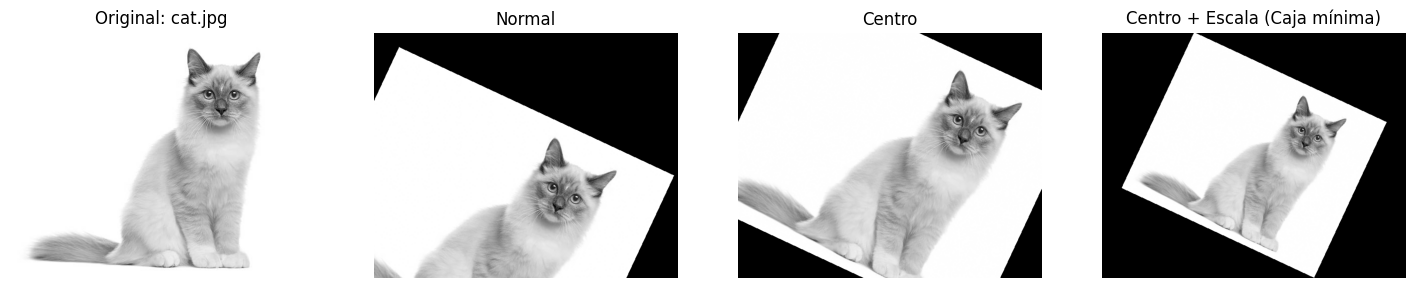


Listo:
 - ./ImagenesCodigoSalidas\salida_normal_cat.jpg
 - ./ImagenesCodigoSalidas\salida_centro_cat.jpg
 - ./ImagenesCodigoSalidas\salida_centro_scaled_cat.jpg


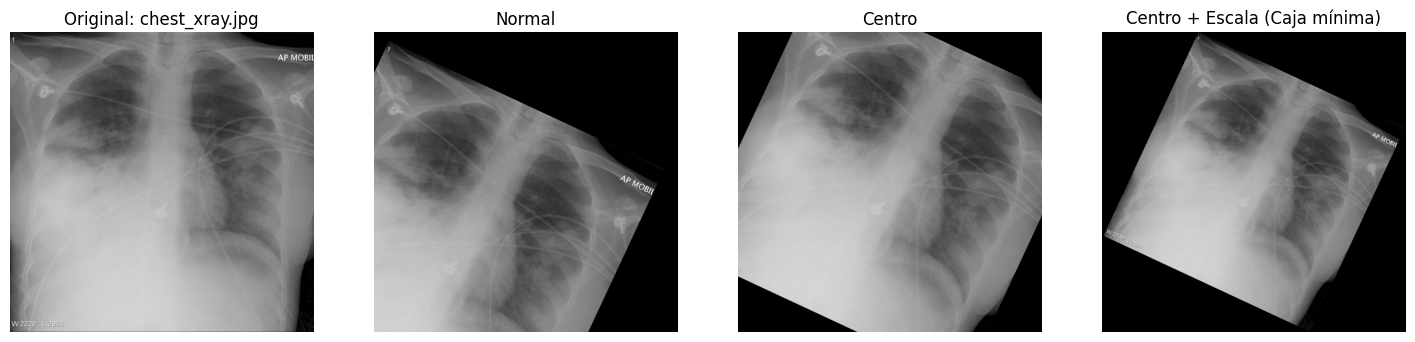


Listo:
 - ./ImagenesCodigoSalidas\salida_normal_chest_xray.jpg
 - ./ImagenesCodigoSalidas\salida_centro_chest_xray.jpg
 - ./ImagenesCodigoSalidas\salida_centro_scaled_chest_xray.jpg


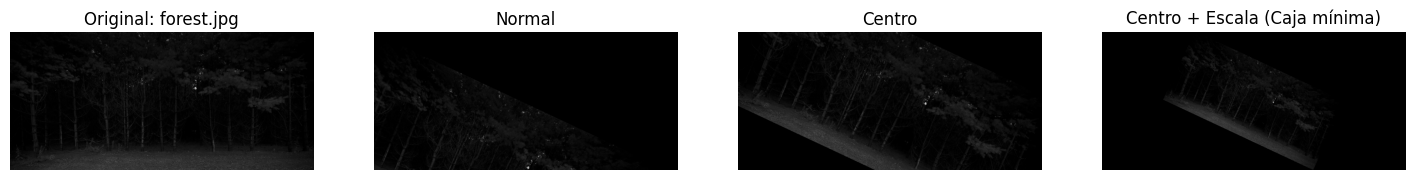


Listo:
 - ./ImagenesCodigoSalidas\salida_normal_forest.jpg
 - ./ImagenesCodigoSalidas\salida_centro_forest.jpg
 - ./ImagenesCodigoSalidas\salida_centro_scaled_forest.jpg


In [ ]:
procesar_carpeta("./ImagenesCodigo", "./ImagenesCodigoSalidas")

# Reporte — Procedimientos, Resultados y Conclusiones
### Procedimientos
1. Se cargó una imagen en escala de grises.
2. Se definió una matriz de transformación afín que incluye rotación y traslación.
3. Se aplicó la transformación inversa píxel por píxel.
4. Para cada coordenada no entera, se aplicó interpolación bilineal.

### Resultados
La imagen transformada conserva suavidad y continuidad gracias a la interpolación.
Se evitan huecos y bordes irregulares comúnmente asociados a transformaciones directas.

### Conclusiones
- La interpolación bilineal permite obtener resultados visualmente consistentes.
- El uso de transformación inversa garantiza que cada píxel de la imagen de salida obtenga un valor válido del origen.
- La estructura modular del código facilita extender este método a transformaciones más complejas.